# **Introduction**

We are eager to continue the conversation, and as a next step, we want to understand how you approach a new situation and apply your expertise.

In advance of the next interviews, we ask candidates to complete a brief exercise (4-8 hours total). Please send your completed exercise (i.e., link to GitHub repo and/or Google Drive) to **Taki Hasegawa** at **taki@reflexai.com** 24 hours before the interviews.

Based on ReflexAI’s mission, you know that we love big, actionable ideas. We also love thinking that is logical, clear, and creative. So make sure these shine through!

---

## **Plan Context**

1. **Dataset**:
   - Download the **AnnoMI dataset**. As described in the paper, the dataset includes transcripts from video demonstrations of high- and low-quality motivational interviewing.
   - The dataset also includes annotations from experienced motivational interviewing practitioners.

2. **Task**:
   - Perform analyses to explore 1 or 2 aspects of the dataset.
   - Create a **text classification model** that predicts the `main_therapist_behaviour` label.
   - Evaluate the model that you created.

3. **Hypothetical Use Case**:
   - The model will be used to characterize the behavior of MI practitioners during their clinical sessions.

---

## **Plan Deliverable**

- The code to perform the above tasks should be delivered as:
  - A **GitHub repository** (set the repository to private).
  - Or a **zip file** shared via Google Drive.

- **Format**:
  - Feel free to use any coding paradigm you like (e.g., modularized code, Jupyter notebooks, or both).
  - Follow **coding best practices**.

- **Be Prepared**:
  - Be ready to present your work.

---

## **Final Note**

That’s it! We realize you might have questions, but we’ve purposely left this assignment broad.

Thank you for your passion and excitement for joining our team. We can’t wait to see your ideas!

In [164]:
# Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning and Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import shap

# Deep Learning with Transformers
import torch
from transformers import BertTokenizer, BertModel
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Saving and Loading Models/Objects
import joblib

In [2]:
# Set a random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Define constants for later use (e.g., paths, hyperparameters)
MODEL_SAVE_PATH = "best_model.pth"
PREPROCESSOR_SAVE_PATH = "preprocessor.joblib"

### Data Loading

In [69]:
DATA_URL = "https://raw.githubusercontent.com/uccollab/AnnoMI/refs/heads/main/AnnoMI-full.csv"
df = pd.read_csv(DATA_URL)

In [70]:
df.sample(5)

,mi_quality,transcript_id,video_title,video_url,topic,utterance_id,interlocutor,timestamp,utterance_text,annotator_id,therapist_input_exists,therapist_input_subtype,reflection_exists,reflection_subtype,question_exists,question_subtype,main_therapist_behaviour,client_talk_type
11771,high,127,Motivational Interviewing A conversation with ...,https://www.youtube.com/watch?v=-RXy8Li3ZaE,asthma management,36,therapist,00:02:41,That's that the only solution.,8,False,NaN,False,NaN,False,NaN,other,NaN
10602,high,113,Dr. Marilyn Herie - MI Skills - Tobacco Cessat...,https://www.youtube.com/watch?v=_YOULz-MPaU,smoking cessation,4,therapist,00:01:01,So I get the impression that there are some th...,5,False,NaN,True,complex,True,open,reflection,NaN
1837,high,22,Values Clarification Handout with Aviyana and ...,https://www.youtube.com/watch?v=8m5-MXX372w&li...,supporting client to live in more alignment wi...,108,therapist,00:08:01,It's gonna be hard to achieve inner harmony-,9,True,advice,False,NaN,False,NaN,therapist_input,NaN
2139,high,29,Part 2: A Non-Diet Approach with Motivational ...,https://www.youtube.com/watch?v=fWFPBSTd830,weight loss,6,therapist,00:01:47,"Um, many people find that when then- when they...",1,True,information,False,NaN,False,NaN,therapist_input,NaN
2040,high,28,Monkey on My Back - Part 1,https://www.youtube.com/watch?v=DXI2N8kEPAs,smoking cessation,30,therapist,00:03:09,Tell me a little bit about what happened with ...,6,False,NaN,False,NaN,True,open,question,NaN


### **Dataset Features Description**

1. **`transcript_id`**:
   - The unique numerical identifier of the conversation/transcript where this utterance belongs.
   - Note: This identifier is **NOT** used for ordering; it is only to distinguish between different conversations in the dataset.

2. **`mi_quality`**:
   - The MI (Motivational Interviewing) quality demonstrated in the conversation/transcript where this utterance belongs.
   - Values: Either `"high"` or `"low"`.

3. **`video_title`**:
   - The title of the original video of the conversation/transcript where this utterance belongs.

4. **`video_url`**:
   - The URL of the original video of the conversation/transcript where this utterance belongs.

5. **`topic`**:
   - The topic(s) of the conversation/transcript where this utterance belongs.

6. **`utterance_id`**:
   - The unique numerical index of this utterance.
   - Note: This identifier **IS** ordering-sensitive. The utterance whose `utterance_id` is `n` is the **n-th utterance** of the conversation (identified by the `transcript_id` of this row) where this utterance belongs.

7. **`interlocutor`**:
   - The interlocutor of this utterance.
   - Values: Either `"therapist"` or `"client"`.

8. **`timestamp`**:
   - The timestamp of this utterance with respect to the original video of the conversation/transcript where this utterance belongs.

9. **`utterance_text`**:
   - The content of this utterance.

10. **`main_therapist_behaviour`**:
    - The (main) therapist behaviour of this utterance.
    - Values: `"n/a"` if the utterance is a client utterance, otherwise one of `["reflection", "question", "therapist_input", "other"]`.

11. **`client_talk_type`**:
    - The client talk type of this utterance.
    - Values: `"n/a"` if the utterance is a therapist utterance, otherwise one of `["change", "neutral", "sustain"]`.

12. **`annotator_id`**:
    - The ID of the annotator who made the annotations for this row.
    - Values range from 0 to 9.

13. **`therapist_input_exists`**:
    - Indicates whether there is input from the therapist in this utterance.
    - Possible values:
      - `"n/a"`: If the utterance is a client utterance.
      - `"True"` or `"False"`: If the utterance is a therapist utterance.

14. **`therapist_input_subtype`**:
    - Specifies the therapist input subtype.
    - Possible values:
      - `"n/a"`: If the utterance is a client utterance or if `therapist_input_exists` is `False`.
      - `"information"`, `"advice"`, `"negotiation"`, or `"options"`: If therapist input exists.

15. **`reflection_exists`**:
    - Indicates whether there is reflection from the therapist in this utterance.
    - Possible values:
      - `"n/a"`: If the utterance is a client utterance.
      - `"True"` or `"False"`: If the utterance is a therapist utterance.

16. **`reflection_subtype`**:
    - Specifies the reflection subtype.
    - Possible values:
      - `"n/a"`: If the utterance is a client utterance or if `reflection_exists` is `False`.
      - `"simple"` or `"complex"`: If reflection exists.

17. **`question_exists`**:
    - Indicates whether there is a question from the therapist in this utterance.
    - Possible values:
      - `"n/a"`: If the utterance is a client utterance.
      - `"True"` or `"False"`: If the utterance is a therapist utterance.

18. **`question_subtype`**:
    - Specifies the question subtype.
    - Possible values:
      - `"n/a"`: If the utterance is a client utterance or if `question_exists` is `False`.
      - `"open"` or `"closed"`: If a question exists.

In [71]:
# Basic info
display(df.info())
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13551 entries, 0 to 13550
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   mi_quality                13551 non-null  object
 1   transcript_id             13551 non-null  int64 
 2   video_title               13551 non-null  object
 3   video_url                 13551 non-null  object
 4   topic                     13551 non-null  object
 5   utterance_id              13551 non-null  int64 
 6   interlocutor              13551 non-null  object
 7   timestamp                 13551 non-null  object
 8   utterance_text            13551 non-null  object
 9   annotator_id              13551 non-null  int64 
 10  therapist_input_exists    6826 non-null   object
 11  therapist_input_subtype   1216 non-null   object
 12  reflection_exists         6826 non-null   object
 13  reflection_subtype        2021 non-null   object
 14  question_exists       

None

,transcript_id,utterance_id,annotator_id
count,13551.000000,13551.000000,13551.000000
mean,67.605933,74.602465,4.647111
std,37.286221,90.373561,2.760160
min,0.000000,0.000000,0.000000
25%,41.000000,17.000000,2.000000
50%,58.000000,42.000000,5.000000
75%,100.000000,99.000000,7.000000
max,133.000000,597.000000,9.000000


### Exploratory Data Analysis (EDA)

In [72]:
## percentage of null values
df.isnull().sum() / df.shape[0] * 100

,0
mi_quality,0.000000
transcript_id,0.000000
video_title,0.000000
video_url,0.000000
topic,0.000000
utterance_id,0.000000
interlocutor,0.000000
timestamp,0.000000
utterance_text,0.000000
annotator_id,0.000000


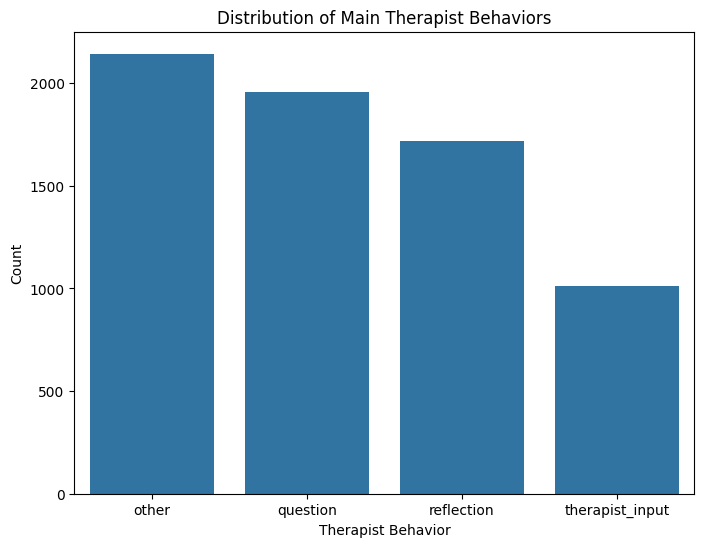

In [73]:
# Plot the distribution
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='main_therapist_behaviour', order=df['main_therapist_behaviour'].value_counts().index)
plt.title('Distribution of Main Therapist Behaviors')
plt.xlabel('Therapist Behavior')
plt.ylabel('Count')
plt.show()

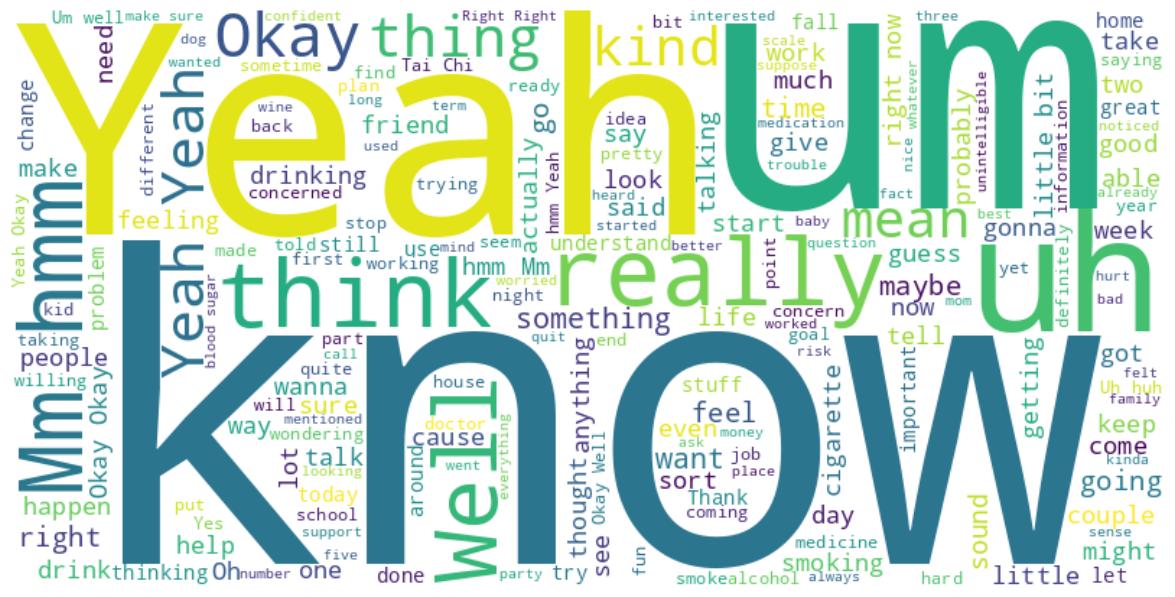

In [74]:
utterances = ' '.join(df['utterance_text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(utterances)

plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [75]:
df['interlocutor'].value_counts()

,count
interlocutor,
therapist,6826
client,6725


In [76]:
# Filtering out entries where main_therapist_behaviour is n/a.
df['main_therapist_behaviour'].isnull().sum()

6725

In [77]:
# Filter therapist utterances with valid behavior labels
df = df[(df['interlocutor'] == 'therapist') & (df['main_therapist_behaviour'] != 'n/a')]
df.reset_index(drop=True, inplace=True)
df.sample(10)

,mi_quality,transcript_id,video_title,video_url,topic,utterance_id,interlocutor,timestamp,utterance_text,annotator_id,therapist_input_exists,therapist_input_subtype,reflection_exists,reflection_subtype,question_exists,question_subtype,main_therapist_behaviour,client_talk_type
2822,high,56,MI Scenario 3 web training,https://www.youtube.com/watch?v=XyqPdDB4dZk,more exercise / increasing activity,130,therapist,00:11:39,Yeah. Takes a lot. Takes a lot. And you're the...,4,False,NaN,True,complex,False,NaN,reflection,NaN
6523,low,72,The Ineffective Athletic Director With a Lower...,https://www.youtube.com/watch?v=X9NBaihCzhk,reducing alcohol consumption; compliance with ...,30,therapist,00:04:52,All right.,2,False,NaN,False,NaN,False,NaN,other,NaN
727,high,20,The Effective Physician: Motivational Intervie...,https://www.youtube.com/watch?v=URiKA7CKtfc,smoking cessation,10,therapist,00:01:40,What made you decide to quit smoking when you ...,0,False,NaN,False,NaN,True,open,question,NaN
4189,high,85,Motivational Interviewing Change Talk: My Meds...,https://www.youtube.com/watch?v=U32rGyGrd90,taking medicine / following medical procedure,88,therapist,00:06:15,"Yet, at the same time, I know running around a...",7,False,NaN,True,complex,True,closed,question,NaN
1500,high,39,Monkey on My Back - Part 2,https://www.youtube.com/watch?v=KNxWYEkzQg8,smoking cessation,42,therapist,00:04:27,"Um, because I know you mentioned you tried the...",1,False,NaN,False,NaN,True,closed,question,NaN
5042,high,109,The Effective Dentist: Motivational Interviewi...,https://www.youtube.com/watch?v=f8QSA_5PEFM&t=...,smoking cessation,10,therapist,00:01:57,The amount you smoke is so miniscule you can't...,2,False,NaN,True,complex,False,NaN,reflection,NaN
6570,low,102,MI-Bad example,https://www.youtube.com/watch?v=tRn3p0F5leU,more exercise / increasing activity,14,therapist,00:01:38,And it seems like if you really want to see th...,2,True,advice,False,NaN,False,NaN,therapist_input,NaN
4467,high,97,Motivational interviewing in brief consultatio...,https://www.youtube.com/watch?v=bTRRNWrwRCo,weight loss,36,therapist,00:01:55,"And, I- I'm sorry about the wait in the waitin...",7,False,NaN,False,NaN,False,NaN,other,NaN
6308,low,27,How NOT to do Motivational Interviewing: A con...,https://www.youtube.com/watch?v=kN7T-cmb_l0,asthma management,16,therapist,00:01:53,"It's you that I'm worried about, Sal. It's you...",4,True,advice,False,NaN,False,NaN,therapist_input,NaN
2580,high,56,MI Scenario 3 web training,https://www.youtube.com/watch?v=XyqPdDB4dZk,more exercise / increasing activity,82,therapist,00:07:38,Mm-hmm.,2,False,NaN,False,NaN,False,NaN,other,NaN


In [78]:
## Encoding the label
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['main_therapist_behaviour'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'other': 0, 'question': 1, 'reflection': 2, 'therapist_input': 3}


In [79]:
# correct the datatypes of the columns
df = df.astype({col: 'category' for col in df.select_dtypes(include='object').columns if col != "timestamp"})
print(df.dtypes)

mi_quality                  category
transcript_id                  int64
video_title                 category
video_url                   category
topic                       category
utterance_id                   int64
interlocutor                category
timestamp                     object
utterance_text              category
annotator_id                   int64
therapist_input_exists      category
therapist_input_subtype     category
reflection_exists           category
reflection_subtype          category
question_exists             category
question_subtype            category
main_therapist_behaviour    category
client_talk_type            category
label_encoded                  int64
dtype: object


In [80]:
df.sample(5)

,mi_quality,transcript_id,video_title,video_url,topic,utterance_id,interlocutor,timestamp,utterance_text,annotator_id,therapist_input_exists,therapist_input_subtype,reflection_exists,reflection_subtype,question_exists,question_subtype,main_therapist_behaviour,client_talk_type,label_encoded
6151,high,133,Motivational interviewing: Ken interviews Daryl,https://www.youtube.com/watch?v=MOVj0FoOxpk&t=...,reducing recidivism,328,therapist,00:22:45,"Right, okay.",6,False,NaN,False,NaN,False,NaN,other,NaN,0
2445,high,56,MI Scenario 3 web training,https://www.youtube.com/watch?v=XyqPdDB4dZk,more exercise / increasing activity,54,therapist,00:05:36,So you're just starting to question a little b...,7,False,NaN,True,complex,False,NaN,reflection,NaN,2
2957,high,56,MI Scenario 3 web training,https://www.youtube.com/watch?v=XyqPdDB4dZk,more exercise / increasing activity,156,therapist,00:13:48,Mm-hmm.,9,False,NaN,False,NaN,False,NaN,other,NaN,0
2372,high,56,MI Scenario 3 web training,https://www.youtube.com/watch?v=XyqPdDB4dZk,more exercise / increasing activity,40,therapist,00:04:17,Mm-hmm. Mm-hmm.,4,False,NaN,False,NaN,False,NaN,other,NaN,0
6348,low,32,A Motivational Interviewing Approach to Studen...,https://youtu.be/NSyKhmEG3f4,compliance with rules,8,therapist,00:02:14,Your behavior is not what Minnesota State Univ...,2,True,information,False,NaN,True,closed,therapist_input,NaN,3


In [81]:
## List to drop the unnecesary columns
num_cols = df.select_dtypes(include = ["int64"]).columns
cat_cols = df.select_dtypes(exclude = ["int64"]).columns

In [82]:
df[num_cols].sample(5)

,transcript_id,utterance_id,annotator_id,label_encoded
2341,56,34,3,1
1544,41,36,6,0
3692,68,195,1,1
4062,84,70,0,2
593,12,16,7,1


In [83]:
df[cat_cols].sample(5)

,mi_quality,video_title,video_url,topic,interlocutor,timestamp,utterance_text,therapist_input_exists,therapist_input_subtype,reflection_exists,reflection_subtype,question_exists,question_subtype,main_therapist_behaviour,client_talk_type
5460,high,Psychotherapy Examples: Part 4 Motivational In...,https://www.youtube.com/watch?v=tvoNEuwcbwk,reducing alcohol consumption,therapist,00:02:10,Okay.,False,NaN,False,NaN,False,NaN,other,NaN
6584,low,The Ineffective Physician: Non-Motivational Ap...,https://www.youtube.com/watch?v=80XyNE89eCs,smoking cessation,therapist,00:04:07,Okay.,False,NaN,False,NaN,False,NaN,other,NaN
3042,high,MI Scenario 3 web training,https://www.youtube.com/watch?v=XyqPdDB4dZk,more exercise / increasing activity,therapist,00:14:31,All right. Thanks.,False,NaN,False,NaN,False,NaN,other,NaN
5507,high,Motivational Interviewing and Employment - wit...,https://www.youtube.com/watch?v=A-3wZrLkZpE,managing life,therapist,00:01:24,You have to provide for your children.,False,NaN,True,simple,False,NaN,reflection,NaN
1363,high,Psychiatric Interviews for Teaching: Somatisation,https://www.youtube.com/watch?v=4-bH55MCa1U,changing approach to disease,therapist,00:10:35,"Okay. Barbara, what was it that you were hopin...",False,NaN,False,NaN,True,open,question,NaN


In [84]:
# List of columns to drop
columns_to_drop = ['video_title', 'video_url', 'timestamp']
df.drop(columns=columns_to_drop, inplace = True)

# Verify the columns have been dropped
print("Remaining columns:", df.columns.tolist())

Remaining columns: ['mi_quality', 'transcript_id', 'topic', 'utterance_id', 'interlocutor', 'utterance_text', 'annotator_id', 'therapist_input_exists', 'therapist_input_subtype', 'reflection_exists', 'reflection_subtype', 'question_exists', 'question_subtype', 'main_therapist_behaviour', 'client_talk_type', 'label_encoded']


### Data Leackage Columns

In [85]:
cols_drop = ['therapist_input_exists', 'therapist_input_subtype', 'reflection_exists', 'reflection_subtype', 'question_exists', 'question_subtype']
df.drop(columns=cols_drop, axis=1, inplace = True)
# Verify remaining columns
print(df.columns)

Index(['mi_quality', 'transcript_id', 'topic', 'utterance_id', 'interlocutor',
       'utterance_text', 'annotator_id', 'main_therapist_behaviour',
       'client_talk_type', 'label_encoded'],
      dtype='object')


In [86]:
## List to drop the unnecesary columns
num_cols = df.select_dtypes(include = ["int64"]).columns
cat_cols = df.select_dtypes(exclude = ["int64"]).columns

In [87]:
for col in cat_cols:
  print(col, df[col].value_counts())

mi_quality mi_quality
high    6178
low      648
Name: count, dtype: int64
topic topic
reducing alcohol consumption                                                          1170
more exercise / increasing activity                                                   1024
reducing recidivism                                                                    654
reducing drug use                                                                      556
diabetes management                                                                    479
smoking cessation                                                                      464
smoking cessation                                                                      273
taking medicine / following medical procedure                                          231
asthma management                                                                      222
avoiding DOI                                                                           197
chan

In [88]:
# interlocutor needs to be dropped because it contains only one constant value
# client_talk_type should also needs to be dropped because it is complete null

cols_drop = ['client_talk_type', 'interlocutor']
df.drop(columns=cols_drop, axis=1, inplace = True)
# Verify remaining columns
print(df.columns)

Index(['mi_quality', 'transcript_id', 'topic', 'utterance_id',
       'utterance_text', 'annotator_id', 'main_therapist_behaviour',
       'label_encoded'],
      dtype='object')


In [89]:
def clean_text(text):
  import re
  """
  Cleans the given text by removing non-alpha numeric characters, and extra whitespace.

  Args:
      text (str): The text to be cleaned.

  Returns:
      str: The cleaned text.
  """
  if not isinstance(text, str):
      return text
  # Remove non-alphanumeric characters except for basic punctuation
  text = re.sub(r'[^a-zA-Z0-9\s.,!?\'"]', '', text)
  # Replace multiple spaces with a single space
  text = re.sub(r'\s+', ' ', text)
  # Strip leading/trailing spaces
  text = text.strip()
  # Convert to lowercase
  text = text.lower()
  return text

In [90]:
df['utterance_text'] = df['utterance_text'].apply(clean_text)

In [93]:
df['utterance_text'].sample(5)

,utterance_text
2898,very normal. absolutely. it's an absolutely no...
4786,good for you doing that.
5400,there's no pickle?
1081,think about all of that.
1267,"right. so, these different tablets that you've..."


### Splitting Data into 80% train and 20% test before Feature Engineering to have zero data leackage

In [91]:
# Features and target
X = df.drop(['main_therapist_behaviour', 'label_encoded'], axis=1)
y = df['label_encoded']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Feature Engineering

In [92]:
X_train.columns

Index(['mi_quality', 'transcript_id', 'topic', 'utterance_id',
       'utterance_text', 'annotator_id'],
      dtype='object')

In [94]:
# Text preprocessing pipeline
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000))
])

# Categorical preprocessing pipeline (One-Hot Encoding)
categorical_features = ['mi_quality', 'topic']
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Numerical preprocessing pipeline
numerical_features = ['utterance_id', 'transcript_id', 'annotator_id']
numerical_pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])


preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'utterance_text'),
    ('categorical', categorical_pipeline, categorical_features),
    ('numerical', numerical_pipeline, numerical_features)
])

In [95]:
# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_transformed = preprocessor.transform(X_test)

In [96]:
# Save the preprocessor pipeline
joblib.dump(preprocessor, 'text2num_pipeline.pkl')

['text2num_pipeline.pkl']

### Model Development

In [97]:
# Initialize the model
logreg = LogisticRegression(max_iter=1000)

# Train the model
logreg.fit(X_train_transformed, y_train)

LogisticRegression(max_iter=1000)

In [98]:
# Initialize the model
svm = LinearSVC(max_iter=1000)

# Train the model
svm.fit(X_train_transformed, y_train)

LinearSVC()

In [99]:
# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_transformed, y_train)

RandomForestClassifier(random_state=42)

In [100]:
# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(label_encoder.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_model.fit(X_train_transformed, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:54:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

## Model Evaluation

In [102]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {acc:.4f}')
    print('Classification Report:')
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [103]:
print('Logistic Regression Performance:')
evaluate_model(logreg, X_test_transformed, y_test)

Logistic Regression Performance:
Accuracy: 0.7657
Classification Report:
                 precision    recall  f1-score   support

          other       0.89      0.83      0.86       429
       question       0.75      0.80      0.77       391
     reflection       0.69      0.72      0.71       344
therapist_input       0.68      0.64      0.66       202

       accuracy                           0.77      1366
      macro avg       0.75      0.75      0.75      1366
   weighted avg       0.77      0.77      0.77      1366



In [104]:
print('SVM Performance:')
evaluate_model(svm, X_test_transformed, y_test)

SVM Performance:
Accuracy: 0.7599
Classification Report:
                 precision    recall  f1-score   support

          other       0.84      0.84      0.84       429
       question       0.76      0.81      0.78       391
     reflection       0.71      0.66      0.69       344
therapist_input       0.66      0.65      0.66       202

       accuracy                           0.76      1366
      macro avg       0.74      0.74      0.74      1366
   weighted avg       0.76      0.76      0.76      1366



In [105]:
print('Random Forest Performance:')
evaluate_model(rf, X_test_transformed, y_test)

Random Forest Performance:
Accuracy: 0.7269
Classification Report:
                 precision    recall  f1-score   support

          other       0.84      0.83      0.83       429
       question       0.70      0.78      0.74       391
     reflection       0.63      0.69      0.66       344
therapist_input       0.72      0.48      0.58       202

       accuracy                           0.73      1366
      macro avg       0.72      0.69      0.70      1366
   weighted avg       0.73      0.73      0.72      1366



In [106]:
print('XgBoost Model Performance:')
evaluate_model(xgb_model, X_test_transformed, y_test)

XgBoost Model Performance:
Accuracy: 0.7511
Classification Report:
                 precision    recall  f1-score   support

          other       0.88      0.86      0.87       429
       question       0.76      0.76      0.76       391
     reflection       0.66      0.69      0.68       344
therapist_input       0.64      0.59      0.62       202

       accuracy                           0.75      1366
      macro avg       0.73      0.73      0.73      1366
   weighted avg       0.75      0.75      0.75      1366



In [110]:
## Logistic Regression is performing better on unseen text data as compare to other model

### Model Explainability and Interpretability

In [120]:
def get_feature_names_from_pipeline(preprocessor):
    feature_names = []

    # Loop through each transformer in the ColumnTransformer
    for name, transformer, columns in preprocessor.transformers_:
        if transformer == 'passthrough':
            # Directly append passthrough features
            feature_names.extend(columns if isinstance(columns, list) else [columns])
        elif hasattr(transformer, 'get_feature_names_out'):
            # Extract feature names from transformers with get_feature_names_out
            feature_names.extend(transformer.get_feature_names_out())
        elif isinstance(transformer, Pipeline):
            last_step = transformer.steps[-1][1]
            if hasattr(last_step, 'get_feature_names_out'):
                # For transformers like OneHotEncoder or TfidfVectorizer
                if isinstance(columns, list):
                    feature_names.extend(last_step.get_feature_names_out(columns))
                else:
                    feature_names.extend(last_step.get_feature_names_out())
            else:
                # Add placeholder names if feature names can't be extracted
                feature_names.extend(columns if isinstance(columns, list) else [columns])
        else:
            # Handle other transformers
            feature_names.extend(columns if isinstance(columns, list) else [columns])

    return feature_names

# Extract all feature names
all_feature_names = get_feature_names_from_pipeline(preprocessor)

In [163]:
# # Logistic Regression SHAP Summary
# shap.summary_plot(
#     shap.LinearExplainer(logreg, X_train_transformed).shap_values(X_test_transformed),
#     X_test_transformed,
#     feature_names=all_feature_names,
#     max_display=5
# )

In [143]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize LIME explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_transformed,
    feature_names=feature_names,
    class_names=[str(c) for c in logreg.classes_],
    mode='classification'
)

# Explain a single prediction (e.g., first instance)
lime_explanation = lime_explainer.explain_instance(
    X_test_transformed.toarray()[0],
    logreg.predict_proba
)

# Visualize the explanation
lime_explanation.show_in_notebook()

### Deep Learning Approach

In [144]:
text_feature = 'utterance_text'

# Categorical features
categorical_features = ['mi_quality', 'topic']

# Numerical features
numerical_features = ['utterance_id', 'transcript_id', 'annotator_id']

In [145]:
# Import necessary libraries
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Categorical preprocessing pipeline
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Numerical preprocessing pipeline
numerical_pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])

# Combine pipelines into ColumnTransformer for additional features
additional_preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_pipeline, categorical_features),
        ('numerical', numerical_pipeline, numerical_features)
    ],
    remainder='drop'
)

train_ntext_features = additional_preprocessor.fit_transform(X_train)
test_ntext_features = additional_preprocessor.transform(X_test)

In [146]:
X_train[text_feature].head(), X_test[text_feature].head()

(5647                                                yeah.
 3625    all right. well, um, one of the things i wante...
 4850                                        mmhmm, mmhmm.
 1642    so more negative things about your drinking, l...
 5230                 is he your fiance or your boyfriend?
 Name: utterance_text, dtype: object,
 3504                                so that's easy to do.
 1836                all right, so i'll see you next week.
 4722                               the big trouble. yeah.
 3638                                               mmhmm.
 4401    you're not sure. so you have a lot of on your ...
 Name: utterance_text, dtype: object)

In [147]:
joblib.dump(additional_preprocessor, 'bert_preprocessor.joblib')

['bert_preprocessor.joblib']

In [148]:
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model = bert_model.to(device)

def get_bert_embeddings_batchwise(text_list, batch_size=32, max_length=128):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

print("Calculating Embeddings on Training Data....")
train_text_embeddings = get_bert_embeddings_batchwise(X_train[text_feature].tolist())
print("Calculating Embeddings on Test Data....")
test_text_embeddings = get_bert_embeddings_batchwise(X_test[text_feature].tolist())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Calculating Embeddings on Training Data....
Calculating Embeddings on Test Data....


In [149]:
print("Shape of train_ntext_features:", train_ntext_features.shape)
print("Shape of train_text_embeddings:", train_text_embeddings.shape)

Shape of train_ntext_features: (5460, 49)
Shape of train_text_embeddings: (5460, 768)


In [150]:
# Preprocess non-text features
if hasattr(train_ntext_features, "toarray"):
    train_ntext_features = train_ntext_features.toarray()

if hasattr(test_ntext_features, "toarray"):
    test_ntext_features = test_ntext_features.toarray()

X_train_bert = np.concatenate([train_ntext_features, train_text_embeddings], axis=1)
X_test_bert = np.concatenate([test_ntext_features, test_text_embeddings], axis=1)

y_train_bert = y_train.values
y_test_bert = y_test.values

In [151]:
print("Shape of X_train_bert:", X_train_bert.shape)
print("Shape of X_test_bert:", X_test_bert.shape)

print("Shape of y_train_bert:", y_train_bert.shape)
print("Shape of y_test_bert:", y_test_bert.shape)

Shape of X_train_bert: (5460, 817)
Shape of X_test_bert: (1366, 817)
Shape of y_train_bert: (5460,)
Shape of y_test_bert: (1366,)


In [155]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch import nn, optim
import numpy as np

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_train_bert, dtype=torch.float32)
y_tensor = torch.tensor(y_train_bert, dtype=torch.long)

# Create a Dataset
dataset = TensorDataset(X_tensor, y_tensor)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the neural network model
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.fc2(out)
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train_bert.shape[1]
num_classes = len(np.unique(y_train_bert))
model = Classifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 5  # Number of epochs to wait before stopping
best_val_loss = float('inf')
early_stop_counter = 0

# Training loop with early stopping
num_epochs = 50
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_dataloader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    # Average losses
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'bert_model_best.pth')
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break

# Save the final model (optional)
# torch.save(model.state_dict(), 'bert_model_final.pth')

Epoch [1/50], Train Loss: 0.8141, Validation Loss: 0.6410
Epoch [2/50], Train Loss: 0.5953, Validation Loss: 0.5946
Epoch [3/50], Train Loss: 0.5600, Validation Loss: 0.5846
Epoch [4/50], Train Loss: 0.5345, Validation Loss: 0.5817
Epoch [5/50], Train Loss: 0.5087, Validation Loss: 0.5579
Epoch [6/50], Train Loss: 0.4956, Validation Loss: 0.5471
Epoch [7/50], Train Loss: 0.4857, Validation Loss: 0.5607
Early stopping counter: 1/5
Epoch [8/50], Train Loss: 0.4760, Validation Loss: 0.5566
Early stopping counter: 2/5
Epoch [9/50], Train Loss: 0.4577, Validation Loss: 0.5248
Epoch [10/50], Train Loss: 0.4502, Validation Loss: 0.5217
Epoch [11/50], Train Loss: 0.4412, Validation Loss: 0.5663
Early stopping counter: 1/5
Epoch [12/50], Train Loss: 0.4363, Validation Loss: 0.5472
Early stopping counter: 2/5
Epoch [13/50], Train Loss: 0.4309, Validation Loss: 0.5402
Early stopping counter: 3/5
Epoch [14/50], Train Loss: 0.4255, Validation Loss: 0.5340
Early stopping counter: 4/5
Epoch [15/50], 

In [161]:
# Generate predictions
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred_logits = model(X_test)
        y_pred = torch.argmax(y_pred_logits, dim=1).cpu().numpy()
    return y_pred

# Convert test set to PyTorch tensors (assuming you've split the data into train/test)
X_test_tensor = torch.tensor(X_test_bert, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_bert, dtype=torch.long)

# Get predictions
y_pred = evaluate_model(model, X_test_tensor, y_test_tensor)

# Evaluate metrics
accuracy = accuracy_score(y_test_bert, y_pred)
precision = precision_score(y_test_bert, y_pred, average='weighted')
recall = recall_score(y_test_bert, y_pred, average='weighted')
f1 = f1_score(y_test_bert, y_pred, average='weighted')

# Detailed classification report
report = classification_report(y_test_bert, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_bert, y_pred)

# Print results
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)


Model Evaluation Metrics:
Accuracy: 0.8082
Precision: 0.8085
Recall: 0.8082
F1 Score: 0.8079

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86       429
           1       0.85      0.87      0.86       391
           2       0.73      0.78      0.75       344
           3       0.72      0.66      0.69       202

    accuracy                           0.81      1366
   macro avg       0.79      0.79      0.79      1366
weighted avg       0.81      0.81      0.81      1366


Confusion Matrix:
 [[365  10  34  20]
 [  4 339  36  12]
 [ 27  31 267  19]
 [ 22  19  28 133]]


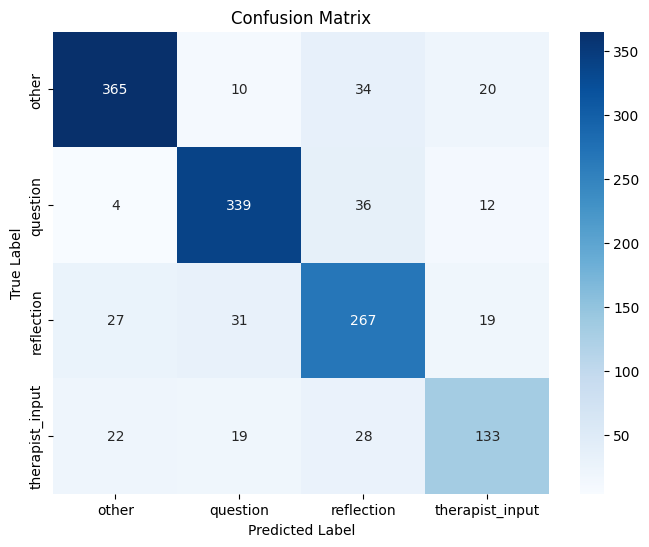

In [162]:
label_mapping = {'other': 0, 'question': 1, 'reflection': 2, 'therapist_input': 3}

# Extract class names in the correct order
class_names = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]

# Plot the confusion matrix
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Example usage
plot_confusion_matrix(conf_matrix, class_names)

In [46]:
# import shap
# import torch
# import numpy as np

# # Define a wrapper to make the PyTorch model compatible with SHAP
# class ModelWrapper:
#     def __init__(self, model):
#         self.model = model
#         self.model.eval()

#     def predict(self, data):
#         # Convert numpy array to tensor
#         data_tensor = torch.tensor(data, dtype=torch.float32)
#         # Get predictions
#         with torch.no_grad():
#             output = self.model(data_tensor)
#         # Return probabilities for SHAP
#         return torch.nn.functional.softmax(output, dim=1).numpy()

# # Wrap the trained PyTorch model
# wrapped_model = ModelWrapper(model)

# # Create a SHAP explainer
# explainer = shap.Explainer(wrapped_model.predict, X_train_bert, max_evals=2 * X_train_bert.shape[1] + 1)
# shap_values = explainer(X_test_bert)

# # Limit the SHAP summary plot to the top 10 features
# shap.summary_plot(
#     shap_values,
#     X_test_bert,
#     feature_names=additional_preprocessor.get_feature_names_out(),
#     max_display=10  # Show top 10 features
# )

### Conclusion

The model demonstrates strong overall performance, particularly in predicting the `other` and `question` classes. However, it struggles with the `therapist_input` and `reflection` classes due to likely data imbalance and feature overlap.

### Recommendations for Improvement:
1. **Address Class Imbalance**:
   - Use techniques like oversampling or loss weighting to balance the dataset.

2. **Enhance Feature Engineering**:
   - Focus on creating more distinctive features to better differentiate between `reflection` and `question`.

3. **Experiment with Alternative Architectures**:
   - Consider using alternative model architectures or fine-tuning hyperparameters for improved generalization.

This analysis suggests that while the model is effective for certain categories, targeted improvements are necessary for better handling of challenging classes.